<a href="https://colab.research.google.com/github/dilek-gokalp/dilek-gokalp/blob/main/Plant_Pathology_2020_(FGVC7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"dilekgokalpp","key":"355a7e93f59ee099908afd5c3b630eea"}'}

In [17]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle --version


Kaggle API 1.7.4.5


In [18]:
!mkdir -p /content/data
!kaggle competitions download -c plant-pathology-2020-fgvc7 -p /content/data
!unzip -q /content/data/plant-pathology-2020-fgvc7.zip -d /content/data/pp2020
!ls -lah /content/data/pp2020 | head -n 20


plant-pathology-2020-fgvc7.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/data/pp2020/images/Test_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: total 252K
drwxr-xr-x 3 root root 4.0K Oct  8 10:53 .
drwxr-xr-x 4 root root 4.0K Oct  8 10:53 ..
drwxr-xr-x 2 root root 128K Oct  8 10:53 images
-rw-r--r-- 1 root root  53K Mar  9  2020 sample_submission.csv
-rw-r--r-- 1 root root  17K Mar  9  2020 test.csv
-rw-r--r-- 1 root root  33K Mar  9  2020 train.csv


In [19]:
import os, shutil, pandas as pd

# 1. Ana klasörleri ayarlayalım
root = '/content/data/pp2020'
img_dir = os.path.join(root, 'images')
out_dir = '/content/data/pp2020_imagefolder'
os.makedirs(out_dir, exist_ok=True)

# 2. Eğitim etiketlerini okuyalım
df = pd.read_csv(os.path.join(root, 'train.csv'))
print("Train CSV boyutu:", df.shape)
print(df.head())

# 3. Etiket sütunlarını bul
label_cols = [c for c in df.columns if c != 'image_id']

# 4. Her satırda hangi sınıf 1 ise onu etiket olarak seç
def row_to_label(row):
    for c in label_cols:
        if int(row[c]) == 1:
            return c
    return 'unknown'

df['label'] = df.apply(row_to_label, axis=1)
print("Sınıflar:", df['label'].unique())

# 5. Her sınıf için klasör oluştur
for cls in sorted(df['label'].unique()):
    os.makedirs(os.path.join(out_dir, cls), exist_ok=True)

# 6. Görselleri uygun klasöre kopyala
moved, missing = 0, 0
for _, r in df.iterrows():
    src = os.path.join(img_dir, f"{r['image_id']}.jpg")
    dst = os.path.join(out_dir, r['label'], f"{r['image_id']}.jpg")
    if os.path.exists(src):
        shutil.copy2(src, dst)
        moved += 1
    else:
        missing += 1

print(f"Kopyalanan görsel: {moved}, bulunamayan: {missing}")
!find /content/data/pp2020_imagefolder -maxdepth 2 -type f | head -n 10


Train CSV boyutu: (1821, 5)
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
Sınıflar: ['scab' 'multiple_diseases' 'healthy' 'rust']
Kopyalanan görsel: 1821, bulunamayan: 0
/content/data/pp2020_imagefolder/multiple_diseases/Train_1577.jpg
/content/data/pp2020_imagefolder/multiple_diseases/Train_1369.jpg
/content/data/pp2020_imagefolder/multiple_diseases/Train_1134.jpg
/content/data/pp2020_imagefolder/multiple_diseases/Train_1013.jpg
/content/data/pp2020_imagefolder/multiple_diseases/Train_1531.jpg
/content/data/pp2020_imagefolder/multiple_diseases/Train_936.jpg
/content/data/pp2020_imagefolder/multiple_diseases/Train_1494.jpg
/content/data/pp2020_imagefolder/multiple_diseases/Train_1018.jpg
/content/data/pp2020_imagefolder/multiple_d

In [20]:
from torchvision import datasets, transforms


DATA_DIR = '/content/data/pp2020_imagefolder'


train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


full_ds = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
print("Total number of images:", len(full_ds))
print("Classes:", full_ds.classes)


Total number of images: 1821
Classes: ['healthy', 'multiple_diseases', 'rust', 'scab']


In [21]:
import os, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())

DATA_DIR = "/content/data/pp2020_imagefolder"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Torch: 2.8.0+cu126 | CUDA: True


In [22]:
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

full_ds = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
class_names = full_ds.classes
num_classes = len(class_names)

n_total = len(full_ds)
n_val   = int(0.15 * n_total)
n_test  = int(0.15 * n_total)
n_train = n_total - n_val - n_test

train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test])
val_ds.dataset.transform = test_tfms
test_ds.dataset.transform = test_tfms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

print("Total:", n_total, "| Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))
print("Classes:", class_names)


Total: 1821 | Train: 1275 Val: 273 Test: 273
Classes: ['healthy', 'multiple_diseases', 'rust', 'scab']


In [24]:
# Model
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
in_f = resnet.fc.in_features
resnet.fc = nn.Linear(in_f, num_classes)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=3e-4)

best_val_acc = 0.0
for epoch in range(1, EPOCHS+1):
    # ---- Train ----
    resnet.train()
    train_correct, train_total, train_loss_sum = 0, 0, 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = resnet(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item() * x.size(0)
        train_correct += (out.argmax(1) == y).sum().item()
        train_total += y.size(0)
    train_acc = train_correct / train_total
    train_loss = train_loss_sum / train_total

    # ---- Val ----
    resnet.eval()
    val_correct, val_total, val_loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = resnet(x)
            loss = criterion(out, y)
            val_loss_sum += loss.item() * x.size(0)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    val_acc = val_correct / val_total
    val_loss = val_loss_sum / val_total


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = resnet.state_dict()

    print(f"Epoch {epoch:02d} | train acc {train_acc:.4f} loss {train_loss:.4f} | val acc {val_acc:.4f} loss {val_loss:.4f}")


resnet.load_state_dict(best_state)


Epoch 01 | train acc 0.8141 loss 0.6159 | val acc 0.9451 loss 0.1887
Epoch 02 | train acc 0.9459 loss 0.1739 | val acc 0.9451 loss 0.1728
Epoch 03 | train acc 0.9796 loss 0.0789 | val acc 0.9524 loss 0.1705
Epoch 04 | train acc 0.9922 loss 0.0313 | val acc 0.9487 loss 0.1925
Epoch 05 | train acc 0.9929 loss 0.0264 | val acc 0.9267 loss 0.3041
Epoch 06 | train acc 0.9867 loss 0.0427 | val acc 0.9487 loss 0.1832
Epoch 07 | train acc 0.9890 loss 0.0458 | val acc 0.9487 loss 0.1829
Epoch 08 | train acc 0.9906 loss 0.0357 | val acc 0.9414 loss 0.2532


<All keys matched successfully>

Test Accuracy (ResNet50): 0.9377289377289377

Classification Report (ResNet50):
                   precision    recall  f1-score   support

          healthy     0.8842    1.0000    0.9385        84
multiple_diseases     0.7500    0.2727    0.4000        11
             rust     0.9895    0.9495    0.9691        99
             scab     0.9494    0.9494    0.9494        79

         accuracy                         0.9377       273
        macro avg     0.8933    0.7929    0.8142       273
     weighted avg     0.9358    0.9377    0.9310       273



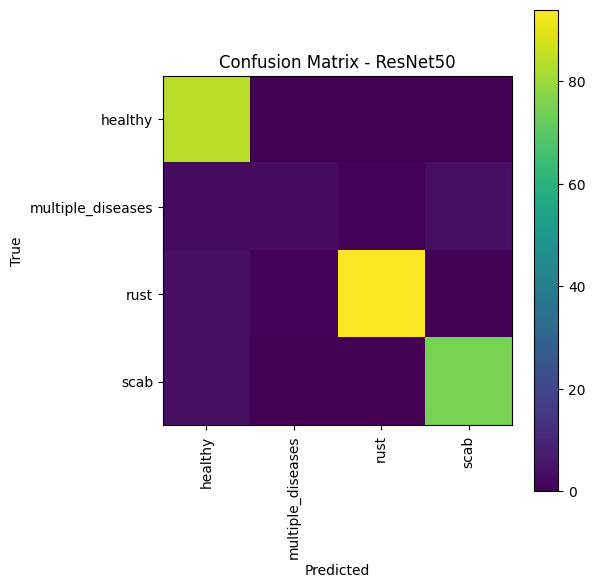

In [25]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

resnet.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_pred.append(resnet(x).argmax(1).cpu().numpy())
        y_true.append(y.cpu().numpy())
y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

print("Test Accuracy (ResNet50):", (y_true == y_pred).mean())
print("\nClassification Report (ResNet50):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix - ResNet50')
plt.colorbar(); ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=90); plt.yticks(ticks, class_names)
plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [26]:
EPOCHS = 3
mobilenet = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
in_f = mobilenet.classifier[-1].in_features
mobilenet.classifier[-1] = nn.Linear(in_f, num_classes)
mobilenet = mobilenet.to(device)

crit = nn.CrossEntropyLoss()
opt  = optim.Adam(mobilenet.parameters(), lr=3e-4)
best_state_m, best_val_acc_m = None, 0.0

for ep in range(1, EPOCHS+1):
    mobilenet.train(); tr_c=tr_t=0; tr_l=0.0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad(); out = mobilenet(x); loss = crit(out,y)
        loss.backward(); opt.step()
        tr_l += loss.item()*x.size(0); tr_c += (out.argmax(1)==y).sum().item(); tr_t += y.size(0)
    tr_acc, tr_loss = tr_c/tr_t, tr_l/tr_t

    mobilenet.eval(); va_c=va_t=0; va_l=0.0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = mobilenet(x); loss = crit(out,y)
            va_l += loss.item()*x.size(0); va_c += (out.argmax(1)==y).sum().item(); va_t += y.size(0)
    va_acc, va_loss = va_c/va_t, va_l/va_t
    if va_acc > best_val_acc_m: best_val_acc_m, best_state_m = va_acc, mobilenet.state_dict()
    print(f"Epoch {ep:02d} | train acc {tr_acc:.4f} loss {tr_loss:.4f} | val acc {va_acc:.4f} loss {va_loss:.4f}")

mobilenet.load_state_dict(best_state_m)


Epoch 01 | train acc 0.7239 loss 0.7865 | val acc 0.8864 loss 0.3654
Epoch 02 | train acc 0.8965 loss 0.2906 | val acc 0.9267 loss 0.2650
Epoch 03 | train acc 0.9569 loss 0.1312 | val acc 0.9341 loss 0.1997


<All keys matched successfully>

Test Accuracy (MobileNetV3-Small): 0.9120879120879121

Classification Report (MobileNetV3-Small):
                   precision    recall  f1-score   support

          healthy     0.8817    0.9762    0.9266        84
multiple_diseases     0.5000    0.0909    0.1538        11
             rust     0.9600    0.9697    0.9648        99
             scab     0.8974    0.8861    0.8917        79

         accuracy                         0.9121       273
        macro avg     0.8098    0.7307    0.7342       273
     weighted avg     0.8993    0.9121    0.8992       273



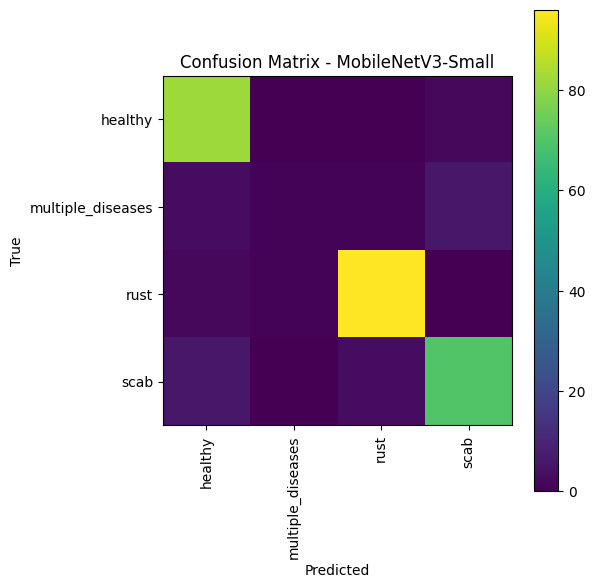

In [27]:
mobilenet.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_pred.append(mobilenet(x).argmax(1).cpu().numpy())
        y_true.append(y.cpu().numpy())
y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

print("Test Accuracy (MobileNetV3-Small):", (y_true == y_pred).mean())
print("\nClassification Report (MobileNetV3-Small):")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix - MobileNetV3-Small')
plt.colorbar(); ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=90); plt.yticks(ticks, class_names)
plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import f1_score

def get_preds(model, loader):
    model.eval(); y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y_pred.append(model(x).argmax(1).cpu().numpy())
            y_true.append(y.numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc = (y_true == y_pred).mean()
    mf1 = f1_score(y_true, y_pred, average='macro')
    return acc, mf1

rows = []
for mdl, name in [(resnet, 'ResNet50'), (mobilenet, 'MobileNetV3-Small')]:
    acc, mf1 = get_preds(mdl, test_loader)
    params = sum(p.numel() for p in mdl.parameters() if p.requires_grad)
    rows.append({'model': name, 'accuracy': round(acc,4), 'macro_f1': round(mf1,4), 'params': int(params)})

df = pd.DataFrame(rows)
print(df)
df.to_csv('results_summary.csv', index=False)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def save_report_and_cm(model, name):
    # preds
    model.eval(); y_true, y_pred = [], []
    with torch.no_grad():
        for x,y in test_loader:
            x = x.to(device)
            y_pred.append(model(x).argmax(1).cpu().numpy())
            y_true.append(y.numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

    # report -> txt
    rep = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    with open(f"{name}_classification_report.txt","w") as f: f.write(rep)

    # cm -> png
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f'Confusion Matrix - {name}')
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=90); plt.yticks(ticks, class_names)
    plt.tight_layout(); plt.xlabel('Predicted'); plt.ylabel('True')
    plt.savefig(f"{name}_confusion_matrix.png", dpi=150, bbox_inches='tight')
    plt.show()

save_report_and_cm(resnet,    "resnet50")
save_report_and_cm(mobilenet, "mobilenetv3_small")
